In [327]:
import numpy as np
import pandas as pd

import csv

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [328]:
# 와인 데이터 가져오기
# numpy로 표현
wine_path = "./winequality-white.csv"
wine_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)
wine_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [329]:
# 마지막 컬럼은 target
# input(X), target(y) 분리하기
n_features = np.size(wine_numpy, 1) - 1

X = wine_numpy[:, 0:n_features]
y = wine_numpy[:, n_features]

In [330]:
# train, val, test 분리
# Pytorch DataLoader, random_split 써도 됨
# 6:2:2
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=42)

In [331]:
# input 정규화
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = torch.tensor(scaler.transform(X_train))
X_val_scaled = torch.tensor(scaler.transform(X_val))
X_test_scaled = torch.tensor(scaler.transform(X_test))

In [332]:
# y 차원 추가
y_train = torch.tensor(y_train).unsqueeze(1)
y_val = torch.tensor(y_val).unsqueeze(1)
y_test = torch.tensor(y_test).unsqueeze(1)

In [333]:
def training_loop(n_epochs, optimizer, scheduler, model, loss_fn, X_train, y_train, X_val, y_val):
    # 시각화용 loss 배열
    train_losses = []
    val_losses = []
    
    # 학습
    for epoch in range(1, n_epochs + 1):
        # training
        model.train()
        train_predict = model(X_train)
        train_loss = loss_fn(train_predict, y_train)
        
        # just evaluation
        with torch.no_grad():
            model.eval()
            val_predict = model(X_val)
            val_loss = loss_fn(val_predict, y_val)
            
        # backward 전 gradients 비우기
        # optimizer.zero_grad()보다 메모리 접근 횟수 적음, 성능에 유리
        for param in model.parameters():
            param.grad = None
        # 기울기 계산
        train_loss.backward()
        # parameters 업데이트
        optimizer.step()
        # learning rate decay
        scheduler.step()
        
        #시각화용 배열에 loss 추가
        if epoch > 150:
            train_losses.append([epoch, train_loss])
            val_losses.append([epoch, val_loss])
        
        # 디버깅용 출력
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}, "f" Validation loss {val_loss.item():.4f}")
            
    return train_losses, val_losses

In [334]:
n_epochs = 5000

seq_model = nn.Sequential(
    nn.Linear(n_features, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1))

learning_rate = 1e-2

optimizer = optim.Adam(seq_model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

loss_fn = nn.MSELoss()

In [335]:
train_losses, val_losses = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    model=seq_model,
    loss_fn=loss_fn,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val)

Epoch 1, Training loss 35.2790,  Validation loss 35.2875
Epoch 2, Training loss 28.0489,  Validation loss 28.1671
Epoch 3, Training loss 15.5996,  Validation loss 15.8081
Epoch 500, Training loss 0.3305,  Validation loss 0.4631
Epoch 1000, Training loss 0.2358,  Validation loss 0.5048
Epoch 1500, Training loss 0.1796,  Validation loss 0.5402
Epoch 2000, Training loss 0.1472,  Validation loss 0.5695
Epoch 2500, Training loss 0.1263,  Validation loss 0.5926
Epoch 3000, Training loss 0.1104,  Validation loss 0.6095
Epoch 3500, Training loss 0.1004,  Validation loss 0.6255
Epoch 4000, Training loss 0.0932,  Validation loss 0.6350
Epoch 4500, Training loss 0.0880,  Validation loss 0.6429
Epoch 5000, Training loss 0.0841,  Validation loss 0.6482


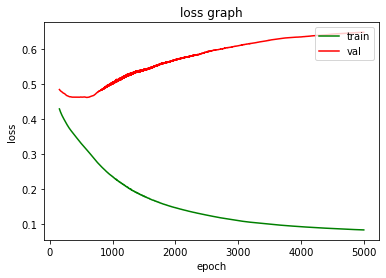

In [336]:
# train loss vs validation loss 비교
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

plt.title('loss graph')
plt.plot(train_losses[:, 0], train_losses[:, 1], c='g', label='train')
plt.plot(val_losses[:, 0], val_losses[:, 1], c='r', label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

In [337]:
# test loss 출력
test_predict = seq_model(X_test_scaled)
test_loss = loss_fn(test_predict, y_test)
print(test_loss)

tensor(0.6834, grad_fn=<MseLossBackward0>)


In [338]:
# 모델에 dropout 추가해서 val, test loss 줄여보기
do_seq_model = nn.Sequential(
    nn.Linear(n_features, 128),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(64, 1))

do_optimizer = optim.Adam(do_seq_model.parameters(), lr=learning_rate)

do_scheduler = optim.lr_scheduler.ExponentialLR(do_optimizer, gamma=0.999)

In [339]:
do_train_losses, do_val_losses = training_loop(
    n_epochs=n_epochs,
    optimizer=do_optimizer,
    scheduler=do_scheduler,
    model=do_seq_model,
    loss_fn=loss_fn,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val)

Epoch 1, Training loss 35.2305,  Validation loss 34.8353
Epoch 2, Training loss 28.5883,  Validation loss 29.3732
Epoch 3, Training loss 18.4416,  Validation loss 18.9823
Epoch 500, Training loss 1.2033,  Validation loss 0.5387
Epoch 1000, Training loss 0.9674,  Validation loss 0.5155
Epoch 1500, Training loss 0.7969,  Validation loss 0.4978
Epoch 2000, Training loss 0.7229,  Validation loss 0.4904
Epoch 2500, Training loss 0.6456,  Validation loss 0.4914
Epoch 3000, Training loss 0.6312,  Validation loss 0.4906
Epoch 3500, Training loss 0.5963,  Validation loss 0.4862
Epoch 4000, Training loss 0.5817,  Validation loss 0.4879
Epoch 4500, Training loss 0.5936,  Validation loss 0.4883
Epoch 5000, Training loss 0.5739,  Validation loss 0.4872


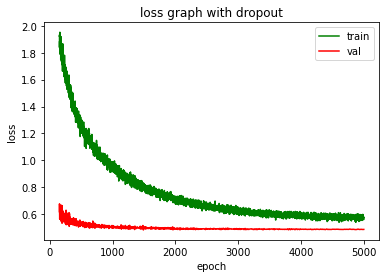

In [340]:
# train loss vs validation loss 비교
do_train_losses = np.array(do_train_losses)
do_val_losses = np.array(do_val_losses)

plt.title('loss graph with dropout')
plt.plot(do_train_losses[:, 0], do_train_losses[:, 1], c='g', label='train')
plt.plot(do_val_losses[:, 0], do_val_losses[:, 1], c='r', label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

In [341]:
# test loss 출력
do_test_predict = do_seq_model(X_test_scaled)
do_test_loss = loss_fn(do_test_predict, y_test)
print(do_test_loss)

tensor(0.4849, grad_fn=<MseLossBackward0>)


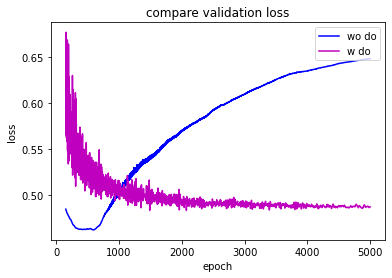

In [342]:
# without dropout vs with dropout validation loss 비교하기
plt.title('compare validation loss')
plt.plot(val_losses[:, 0], val_losses[:, 1], c='b', label='wo do')
plt.plot(do_val_losses[:, 0], do_val_losses[:, 1], c='m', label='w do')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

In [344]:
# without dropout vs with dropout test loss 비교하기
print(f"Test Loss without Dropout: {test_loss}")
print(f"Test Loss with Dropout: {do_test_loss}")

Test Loss without Dropout: 0.6834366917610168
Test Loss with Dropout: 0.48485901951789856
